In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import graphviz
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def perf_eval(cm, y_true, y_pred_proba):
  _tp = cm[1, 1]
  _fn = cm[1, 0]
  _fp = cm[0, 1]
  _tn = cm[0, 0]
  # True positive rate: TPR (Recall)
  TPR = _tp / (_tp + _fn)
  # Precision
  PRE = _tp/(_tp+_fp)
  # True negative rate: TNR
  TNR = _tn/(_tn+_fp)
  # Simple Accuracy
  ACC = (_tp + _tn) / np.sum(cm)
  # Balanced Correction Rate
  BCR = np.sqrt(TPR*TNR)
  # F1-Measure
  F1 = 2*TPR*PRE/(TPR+PRE)
  # AUROC
  AUROC = roc_auc_score(y_true, y_pred_proba)
  return TPR, PRE, TNR, ACC, BCR, F1, AUROC

In [ ]:
#데이터 전처리
rice_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/riceClassification.csv")
print(rice_df.info())
rice_df['Class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None


Class
1    9985
0    8200
Name: count, dtype: int64

In [ ]:
#결측치 존재성 확인
missing_values = rice_df.isnull().sum()
print(missing_values)

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64


In [ ]:
#데이터셋 분할

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

x=rice_df.drop(columns=['id', 'Class'])
y=rice_df['Class']

x_train, x_temp, y_train, y_temp=train_test_split(x, y, test_size=0.3, random_state=12345)
x_val, x_test, y_val, y_test=train_test_split(x_temp, y_temp, test_size=0.5, random_state=12345)

In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["Full Tree", "Pre-Pruning", "NN", 'LR'],columns = ["TPR", "Precision", "TNR","Accuracy", "BCR", "F1-Measure", "AUROC"])
print(Perf_Table)

             TPR Precision  TNR Accuracy  BCR F1-Measure AUROC
Full Tree    NaN       NaN  NaN      NaN  NaN        NaN   NaN
Pre-Pruning  NaN       NaN  NaN      NaN  NaN        NaN   NaN
NN           NaN       NaN  NaN      NaN  NaN        NaN   NaN
LR           NaN       NaN  NaN      NaN  NaN        NaN   NaN


In [ ]:
# Classification and Regression Tree (CART) --------------------------------------
# Full Tree 학습 및 성능 평가
clf=DecisionTreeClassifier(random_state=12345)
clf.fit(x_train, y_train)
y_pred_full=clf.predict(x_test)
y_pred_proba_full = clf.predict_proba(x_test)[:, 1]  # 각 클래스에 대한 확률

# 트리 깊이 확인
tree_depth = clf.get_depth()
print(f"Tree Depth: {tree_depth}")

# 리프 노드 개수 확인
num_leaves = clf.tree_.n_leaves
print(f"Number of Leaf Nodes: {num_leaves}")

cm_full=confusion_matrix(y_test, y_pred_full)
perf_full=perf_eval(cm_full, y_test , y_pred_proba_full)

Perf_Table.loc["Full Tree"]=perf_full
print(Perf_Table)

Tree Depth: 14
Number of Leaf Nodes: 141
                 TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree    0.98796  0.985324  0.982157  0.985337  0.985054    0.98664   
Pre-Pruning      NaN       NaN       NaN       NaN       NaN        NaN   
NN               NaN       NaN       NaN       NaN       NaN        NaN   
LR               NaN       NaN       NaN       NaN       NaN        NaN   

                AUROC  
Full Tree    0.985059  
Pre-Pruning       NaN  
NN                NaN  
LR                NaN  


In [ ]:
#Pre-Prunning(사전적 가지치기)

criterion = ['gini', 'entropy']
max_depth = [None, 3, 6, 9]
min_split = [2, 5, 10]
min_leaf = [1, 2, 4]

param_grid = {'criterion': criterion, 'min_samples_split': min_split, 'max_depth': max_depth,  'min_samples_leaf': min_leaf}

from sklearn.model_selection import ParameterGrid

best_auroc=0.0
best_model_pre=None

for params in ParameterGrid(param_grid):
  model=DecisionTreeClassifier(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_pred=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc:
    best_auroc=auroc
    best_model_pre=model

y_test_pred=best_model_pre.predict(x_test)
y_test_proba = best_model_pre.predict_proba(x_test)[:, 1]
test_auroc=roc_auc_score(y_test, best_model_pre.predict_proba(x_test)[:,1])

print(best_model_pre.get_params())
print(test_auroc)

# 말단 노드 개수 확인
num_leaves = best_model_pre.get_n_leaves()
print(f"Number of leaf nodes: {num_leaves}")

# 성능 평가
cm_pre = confusion_matrix(y_test, y_test_pred)
perf_pre = perf_eval(cm_pre, y_test, y_test_proba)

# 성능 테이블에 추가
Perf_Table.loc["Pre-Pruning"] = perf_pre
print(Perf_Table)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
0.9972921362638911
Number of leaf nodes: 35
                  TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.98796  0.985324  0.982157  0.985337  0.985054    0.98664   
Pre-Pruning  0.989298  0.988636  0.986212  0.987903  0.987754   0.988967   
NN                NaN       NaN       NaN       NaN       NaN        NaN   
LR                NaN       NaN       NaN       NaN       NaN        NaN   

                AUROC  
Full Tree    0.985059  
Pre-Pruning  0.997292  
NN                NaN  
LR                NaN  


In [ ]:
#사전적 가지치기
# 사용된 변수의 인덱스 (양수인 것만 세면 됩니다)
used_features_indices = np.nonzero(best_model_pre.tree_.feature >= 0)[0]
used_features = set(best_model_pre.tree_.feature[used_features_indices])

# 변수명 추출
used_feature_names = [x.columns[i] for i in used_features]

print(f"분기에 사용된 변수 수: {len(used_features)}")
print("사용된 변수 인덱스:", used_features)
print("사용된 변수명:", used_feature_names)

분기에 사용된 변수 수: 10
사용된 변수 인덱스: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
사용된 변수명: ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness', 'AspectRation']


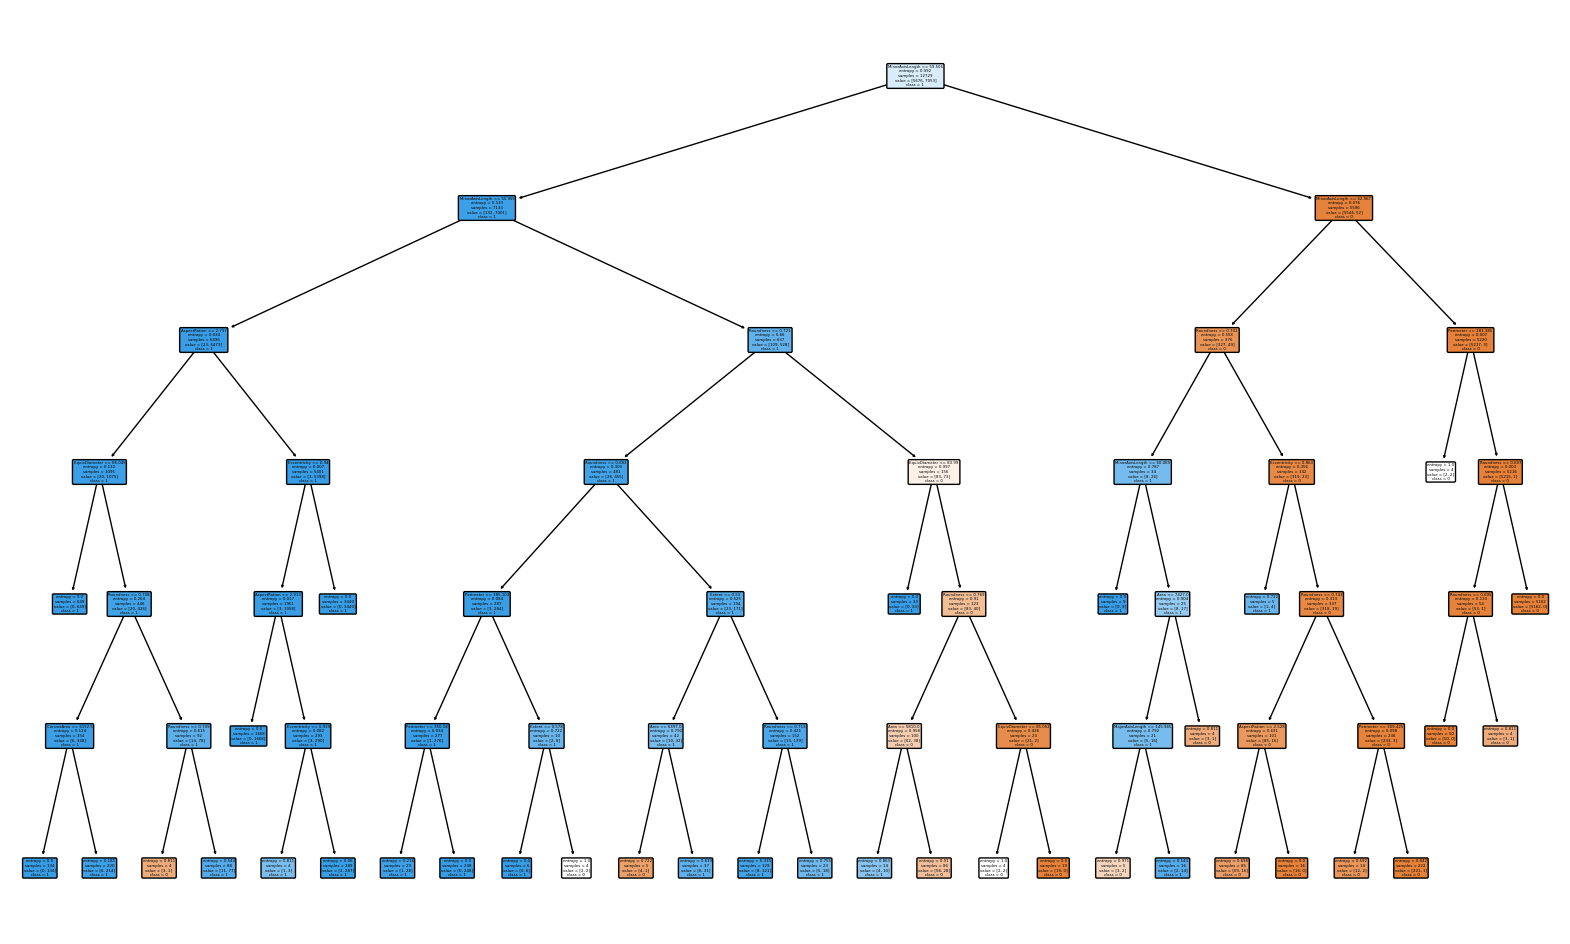

In [ ]:
#사전적 가지치기 plot
plt.figure(figsize=(20,12))
plot_tree(best_model_pre, feature_names=x.columns, class_names=['0', '1'], rounded=True, filled=True)
plt.savefig("best_model_pre.pdf") #pdf로 저장
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#최적의 파라미터 찾기(ANN)

param_grid_q6 = {'hidden_layer_sizes': [(50,), (100,), (200,)],
                 'activation': ['relu', 'tanh', 'logistic'],
                 'solver': ['adam', 'sgd', 'lbfgs'],
                 'learning_rate':['constant', 'invscaling', 'adaptive'],
                 'max_iter':[100,200,500]}


best_auroc=0.0
best_model_ann=None

for params in ParameterGrid(param_grid_q6):
  model=MLPClassifier(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc:
    best_auroc=auroc
    best_model_ann=model

y_test_pred_ann=best_model_ann.predict(x_test)
test_auroc_ann=roc_auc_score(y_test, best_model_ann.predict_proba(x_test)[:,1])

print(best_model_ann.get_params())
print(test_auroc_ann)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 12345, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.9983150105650899


In [ ]:
# 혼동 행렬 계산
cm_ann = confusion_matrix(y_test, y_test_pred_ann)
perf_ann = perf_eval(cm_ann, y_test, y_test_proba)

# 성능 테이블에 추가
Perf_Table.loc["NN"] = perf_ann
print(Perf_Table)

                  TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.98796  0.985324  0.982157  0.985337  0.985054    0.98664   
Pre-Pruning  0.989298  0.988636  0.986212  0.987903  0.987754   0.988967   
NN           0.996656  0.984798  0.981346  0.989736  0.988971   0.990691   
LR                NaN       NaN       NaN       NaN       NaN        NaN   

                AUROC  
Full Tree    0.985059  
Pre-Pruning  0.997292  
NN           0.997292  
LR                NaN  


In [ ]:
#최적의 파라미터 찾기(LR)

param_grid_q10 = {'penalty': ['l1', 'l2'],
                 'C': [0.001, 0.01, 0.1, 1, 10],
                 'solver':['liblinear', 'saga'],
                 'max_iter':[100, 200, 500]
                 }


best_auroc_logi=0.0
best_model_logi=None

for params in ParameterGrid(param_grid_q10):
  model=LogisticRegression(**params, random_state=12345)
  model.fit(x_train, y_train)
  y_val_logi=model.predict(x_val)
  auroc=roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
  if auroc>best_auroc_logi:
    best_auroc_logi=auroc
    best_model_logi=model

y_test_pred=best_model_logi.predict(x_test)
y_test_pred_proba = best_model_logi.predict_proba(x_test)[:, 1]
test_auroc_logi=roc_auc_score(y_test, best_model_logi.predict_proba(x_test)[:,1])

print(best_model_logi.get_params())
print(test_auroc_logi)

{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.9987370716663005


In [ ]:
# Confusion matrix 생성
cm = confusion_matrix(y_test, y_test_pred)
# 성능 지표 계산
TPR, PRE, TNR, ACC, BCR, F1, AUROC = perf_eval(cm, y_test, y_test_pred_proba)
# "LR" 행에 성능 지표 채우기
Perf_Table.loc['LR'] = [TPR, PRE, TNR, ACC, BCR, F1, AUROC]
print(Perf_Table)

                  TPR Precision       TNR  Accuracy       BCR F1-Measure  \
Full Tree     0.98796  0.985324  0.982157  0.985337  0.985054    0.98664   
Pre-Pruning  0.989298  0.988636  0.986212  0.987903  0.987754   0.988967   
NN           0.996656  0.984798  0.981346  0.989736  0.988971   0.990691   
LR           0.996656  0.986755  0.983779  0.990836  0.990197   0.991681   

                AUROC  
Full Tree    0.985059  
Pre-Pruning  0.997292  
NN           0.997292  
LR           0.998737  
